## Heat content checks

This notebook is for checking how heat content anomalies and heat transport terms evolves over time.

In [1]:
import numpy as np
import math
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import dask

import warnings
warnings.filterwarnings('ignore')

In [2]:
def plot_sec(ax, da, vmin=-999, vmax=999, levels=9, lat_lon_ext = [-180, 180, -85., 85.],
             lon='geolon', lat='geolat', cmap='RdBu_r', title='what is it?'):
        
    p = da.plot.contourf(ax=ax, x=lon, y=lat, vmin=vmin, vmax=vmax, levels = levels, cmap=cmap, 
                transform=ccrs.PlateCarree(), add_labels=False, add_colorbar=False, extend='both')
    
    # add separate colorbar
    cb = plt.colorbar(p, ax=ax, extend='both', shrink=0.6) # orientation="horizontal"
    cb.ax.tick_params(labelsize=12)
    
    ax.set_extent(lat_lon_ext, crs=ccrs.PlateCarree())
    
    # parallels/meridiens
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    #gl.ylocator = mticker.FixedLocator([-80, -70, -60, -50, -40, -30])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}

    ax.set_aspect(1.0)

    #p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
    
    _ = plt.title(title, fontsize=14)
    
    ax.add_feature(cfeature.LAND) #, zorder=100, edgecolor='k') #, facecolor='black')
    #ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    
    return fig, cb 

In [3]:
ppdir = "/gws/nopw/j04/snapdragon/hkhatri/Data_Composite/NAO/"

ds_NAOp = xr.open_mfdataset(ppdir + "*NAOp*nc", chunks={'time':1, 'lev':5})

ds_NAOn = xr.open_mfdataset(ppdir + "*NAOn*nc", chunks={'time':1, 'lev':5})

ds_grid = xr.open_dataset("/home/users/hkhatri/DePreSys4_Data/Data_Consolidated/Ocean_Area_Updated.nc")
dz = ds_grid['dz_t'].rename({'deptht':'lev'})

In [4]:
print(ds_NAOp)

print(ds_NAOp.lev.values)

<xarray.Dataset>
Dimensions:    (time: 125, lev: 75, j: 450, i: 450)
Coordinates:
  * time       (time) object 1960-11-16 00:00:00 ... 1971-03-16 00:00:00
  * lev        (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * j          (j) int32 699 700 701 702 703 704 ... 1144 1145 1146 1147 1148
  * i          (i) int32 749 750 751 752 753 754 ... 1194 1195 1196 1197 1198
    latitude   (j, i) float32 dask.array<chunksize=(450, 450), meta=np.ndarray>
    longitude  (j, i) float32 dask.array<chunksize=(450, 450), meta=np.ndarray>
Data variables:
    thetao     (time, lev, j, i) float32 dask.array<chunksize=(1, 5, 450, 450), meta=np.ndarray>
[5.05760014e-01 1.55585527e+00 2.66768169e+00 3.85627985e+00
 5.14036131e+00 6.54303360e+00 8.09251881e+00 9.82275009e+00
 1.17736797e+01 1.39910383e+01 1.65253220e+01 1.94298019e+01
 2.27576160e+01 2.65583000e+01 3.08745613e+01 3.57402039e+01
 4.11800232e+01 4.72118950e+01 5.38506355e+01 6.11128387e+01
 6.90216827e+01 7.76111603e+01 8.692942

In [5]:
ds_mask = xr.open_dataset("../../../../DePreSys4_Data/Data_Consolidated/Mask_Regions.nc")

ds_grid = xr.open_dataset("/home/users/hkhatri/DePreSys4_Data/Data_Consolidated/Ocean_Area_Updated.nc")

ds_mask['dx'] = ds_grid['dx_t'].rename({'x':'i', 'y':'j'})
ds_mask['area'] = ds_grid['area_t'].rename({'x':'i', 'y':'j'})

print(ds_mask)

<xarray.Dataset>
Dimensions:         (j: 450, i: 450)
Coordinates:
  * j               (j) int64 699 700 701 702 703 ... 1144 1145 1146 1147 1148
  * i               (i) int64 749 750 751 752 753 ... 1194 1195 1196 1197 1198
    nav_lat         (j, i) float32 ...
    nav_lon         (j, i) float32 ...
Data variables:
    mask_regions    (j, i) float64 ...
    mask_North_Atl  (j, i) float64 ...
    dx              (j, i) float32 ...
    area            (j, i) float32 ...


In [6]:
rho_cp = 4.09 * 1.e6

Q = (rho_cp * ds_NAOp['thetao'] * dz).where(ds_mask['mask_North_Atl']== 0.)

In [7]:
print(Q)

<xarray.DataArray (time: 125, lev: 75, j: 450, i: 450)>
dask.array<where, shape=(125, 75, 450, 450), dtype=float32, chunksize=(1, 5, 450, 450), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) object 1960-11-16 00:00:00 ... 1971-03-16 00:00:00
  * lev        (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * j          (j) int32 699 700 701 702 703 704 ... 1144 1145 1146 1147 1148
  * i          (i) int32 749 750 751 752 753 754 ... 1194 1195 1196 1197 1198
    latitude   (j, i) float32 dask.array<chunksize=(450, 450), meta=np.ndarray>
    longitude  (j, i) float32 dask.array<chunksize=(450, 450), meta=np.ndarray>
    nav_lat    (j, i) float32 ...
    nav_lon    (j, i) float32 ...


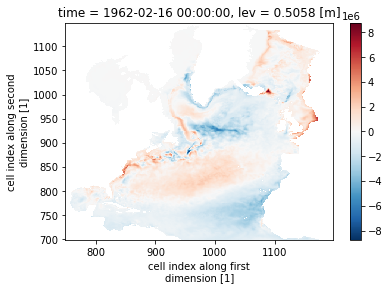

In [8]:
Q.isel(time=15,lev=0).plot()

In [9]:
print( ds_NAOp.lev.values[39],  ds_NAOp.lev.values[46], ds_NAOp.lev.values[56])

508.639892578125 1045.854248046875 2429.025146484375


In [10]:
%time Q_500 = Q.isel(lev=slice(0,40)).sum('lev').compute()
%time Q_1000 = Q.isel(lev=slice(40,47)).sum('lev').compute()
%time Q_2500 = Q.isel(lev=slice(47,57)).sum('lev').compute()

CPU times: user 12.3 s, sys: 11.9 s, total: 24.2 s
Wall time: 35 s
CPU times: user 3.02 s, sys: 2.53 s, total: 5.55 s
Wall time: 11.6 s
CPU times: user 3.52 s, sys: 1.77 s, total: 5.29 s
Wall time: 7.62 s


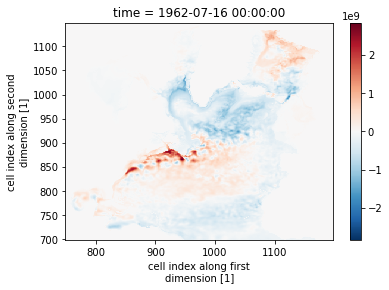

In [11]:
(Q_500.isel(time=20)).plot()

Text(0.5, 1.0, '1000-2500 m, zonal mean')

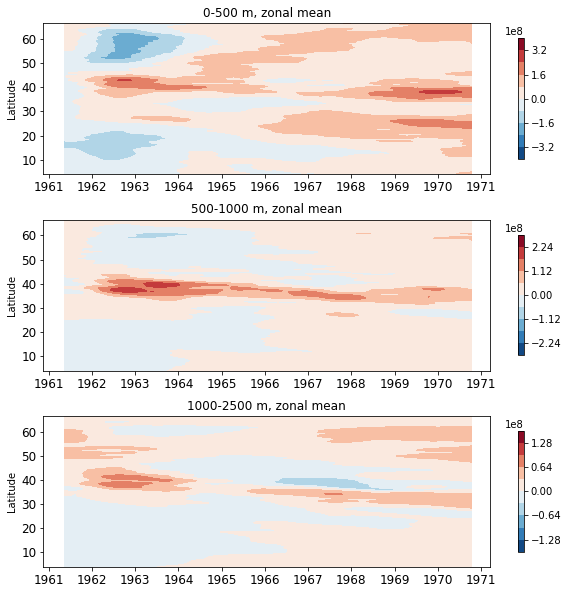

In [15]:
lat = ds_NAOp['latitude'].where(ds_mask['mask_North_Atl']== 0.).mean('i').isel(j=slice(0,350))
dx = ds_mask['dx'].where(ds_mask['mask_North_Atl']== 0.)

levels = np.linspace(-4e8, 4e8,11)

grid1 = plt.GridSpec(3, 1, wspace=0.3, hspace=0.3)
fig = plt.figure(figsize=[10,10])

ax = fig.add_subplot(grid1[0, 0])

tmp = (Q_500.rolling(time=12, center=True).mean('time')).mean('i').isel(j=slice(0,350))

p = ax.contourf(ds_NAOp.time.astype("datetime64[ns]"), lat, tmp.transpose(), levels=levels, cmap='RdBu_r')
cb = plt.colorbar(p, ax=ax, shrink=0.8)
plt.yticks(fontsize = 12);
plt.xticks(fontsize = 12);
ax.set_ylabel('Latitude')
ax.set_title('0-500 m, zonal mean') 

ax = fig.add_subplot(grid1[1, 0])

tmp = (Q_1000.rolling(time=12, center=True).mean('time')).mean('i').isel(j=slice(0,350)) 

p = ax.contourf(ds_NAOp.time.astype("datetime64[ns]"), lat, tmp.transpose(), levels=levels*.7, cmap='RdBu_r')
cb = plt.colorbar(p, ax=ax, shrink=0.8)
plt.yticks(fontsize = 12);
plt.xticks(fontsize = 12);
ax.set_ylabel('Latitude')
ax.set_title('500-1000 m, zonal mean') 

ax = fig.add_subplot(grid1[2, 0])

tmp = (Q_2500.rolling(time=12, center=True).mean('time')).mean('i').isel(j=slice(0,350)) 

p = ax.contourf(ds_NAOp.time.astype("datetime64[ns]"), lat, tmp.transpose(), levels=levels*0.4, cmap='RdBu_r')
cb = plt.colorbar(p, ax=ax, shrink=0.8)
plt.yticks(fontsize = 12);
plt.xticks(fontsize = 12);
ax.set_ylabel('Latitude')
ax.set_title('1000-2500 m, zonal mean') 

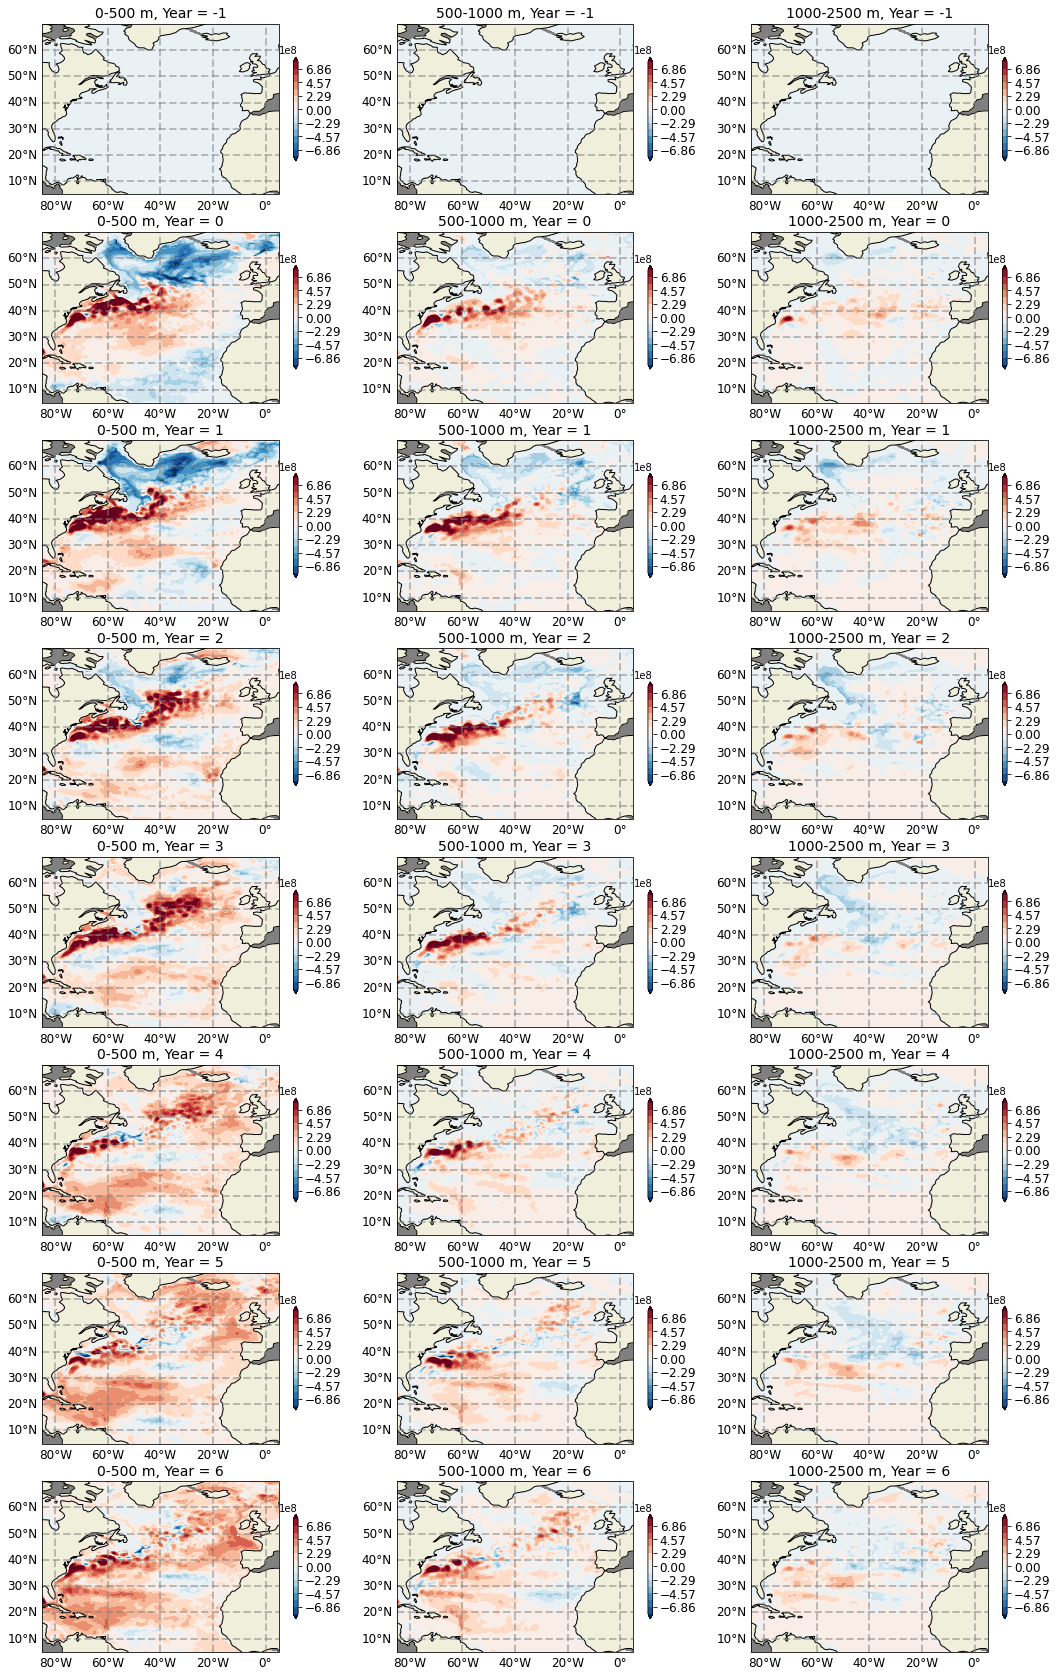

In [18]:
tmp500 = (Q_500).rolling(time=12, center=True).mean('time').where(ds_mask['mask_North_Atl']== 0.)
tmp1000 = (Q_1000).rolling(time=12, center=True).mean('time').where(ds_mask['mask_North_Atl']== 0.)
tmp2500 = (Q_2500).rolling(time=12, center=True).mean('time').where(ds_mask['mask_North_Atl']== 0.)

lat_lon_ext = [-85., 5., 5., 70.]

grid1 = plt.GridSpec(8, 3, wspace=0.2, hspace=0.2)
fig = plt.figure(figsize=[18,30])

for i in range(0,8):
    
    ax = fig.add_subplot(grid1[i, 0], projection=ccrs.PlateCarree(),facecolor='grey')
    [p, cb] = plot_sec(ax, tmp500.isel(time=i*12 + 6) - tmp500.isel(time=6), vmin=-0.8e9, vmax=0.8e9,  lat_lon_ext = lat_lon_ext, levels = 15,
                       lon='longitude', lat='latitude', cmap='RdBu_r', title='0-500 m, Year = ' + str(i-1))
    
    ax = fig.add_subplot(grid1[i, 1], projection=ccrs.PlateCarree(),facecolor='grey')
    [p, cb] = plot_sec(ax, tmp1000.isel(time=i*12 + 6) - tmp1000.isel(time=6), vmin=-0.8e9, vmax=0.8e9,  lat_lon_ext = lat_lon_ext, levels = 15,
                       lon='longitude', lat='latitude', cmap='RdBu_r', title='500-1000 m, Year = ' + str(i-1))
    
    ax = fig.add_subplot(grid1[i, 2], projection=ccrs.PlateCarree(),facecolor='grey')
    [p, cb] = plot_sec(ax, tmp2500.isel(time=i*12 + 6) - tmp2500.isel(time=6), vmin=-0.8e9, vmax=0.8e9,  lat_lon_ext = lat_lon_ext, levels = 15,
                       lon='longitude', lat='latitude', cmap='RdBu_r', title='1000-2500 m, Year = ' + str(i-1))

#### For NAOn


In [19]:
Q = (rho_cp * ds_NAOn['thetao'] * dz).where(ds_mask['mask_North_Atl']== 0.)

%time Q_500 = Q.isel(lev=slice(0,40)).sum('lev').compute()
%time Q_1000 = Q.isel(lev=slice(40,47)).sum('lev').compute()
%time Q_2500 = Q.isel(lev=slice(47,57)).sum('lev').compute()

CPU times: user 11.2 s, sys: 3.26 s, total: 14.4 s
Wall time: 34.8 s
CPU times: user 2.83 s, sys: 914 ms, total: 3.75 s
Wall time: 11.8 s
CPU times: user 3.79 s, sys: 1.22 s, total: 5.01 s
Wall time: 6.03 s


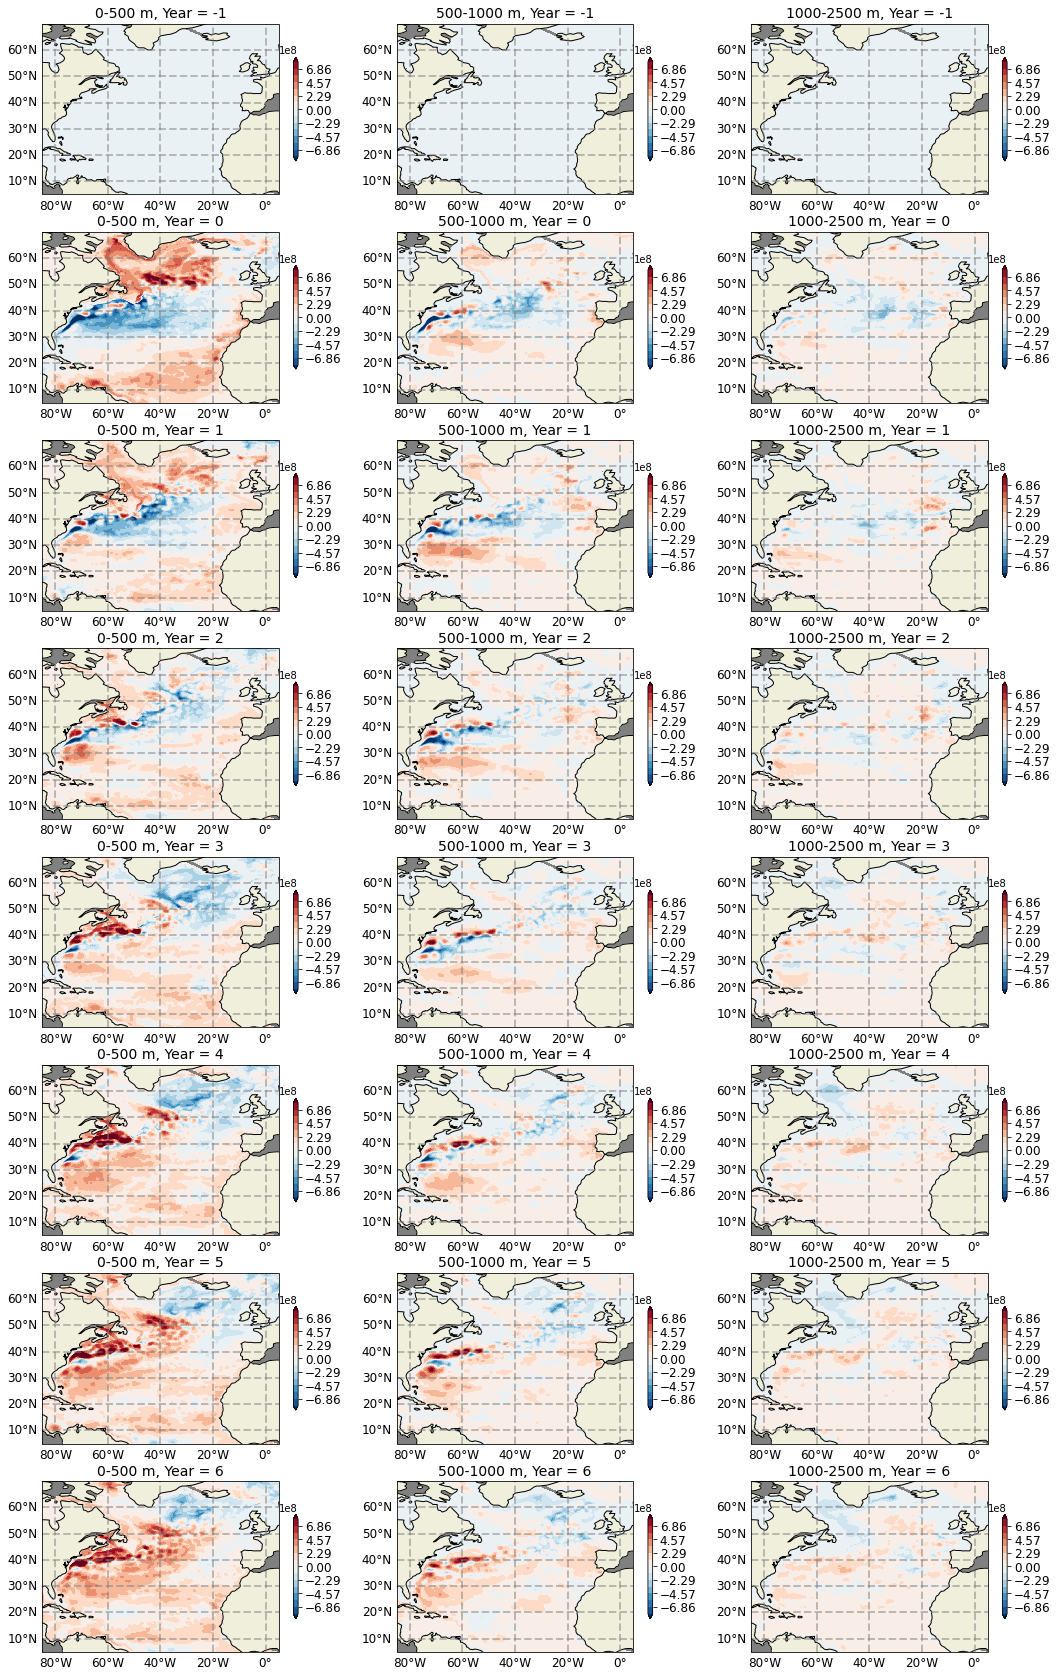

In [20]:
tmp500 = (Q_500).rolling(time=12, center=True).mean('time').where(ds_mask['mask_North_Atl']== 0.)
tmp1000 = (Q_1000).rolling(time=12, center=True).mean('time').where(ds_mask['mask_North_Atl']== 0.)
tmp2500 = (Q_2500).rolling(time=12, center=True).mean('time').where(ds_mask['mask_North_Atl']== 0.)

lat_lon_ext = [-85., 5., 5., 70.]

grid1 = plt.GridSpec(8, 3, wspace=0.2, hspace=0.2)
fig = plt.figure(figsize=[18,30])

for i in range(0,8):
    
    ax = fig.add_subplot(grid1[i, 0], projection=ccrs.PlateCarree(),facecolor='grey')
    [p, cb] = plot_sec(ax, tmp500.isel(time=i*12 + 6) - tmp500.isel(time=6), vmin=-0.8e9, vmax=0.8e9,  lat_lon_ext = lat_lon_ext, levels = 15,
                       lon='longitude', lat='latitude', cmap='RdBu_r', title='0-500 m, Year = ' + str(i-1))
    
    ax = fig.add_subplot(grid1[i, 1], projection=ccrs.PlateCarree(),facecolor='grey')
    [p, cb] = plot_sec(ax, tmp1000.isel(time=i*12 + 6) - tmp1000.isel(time=6), vmin=-0.8e9, vmax=0.8e9,  lat_lon_ext = lat_lon_ext, levels = 15,
                       lon='longitude', lat='latitude', cmap='RdBu_r', title='500-1000 m, Year = ' + str(i-1))
    
    ax = fig.add_subplot(grid1[i, 2], projection=ccrs.PlateCarree(),facecolor='grey')
    [p, cb] = plot_sec(ax, tmp2500.isel(time=i*12 + 6) - tmp2500.isel(time=6), vmin=-0.8e9, vmax=0.8e9,  lat_lon_ext = lat_lon_ext, levels = 15,
                       lon='longitude', lat='latitude', cmap='RdBu_r', title='1000-2500 m, Year = ' + str(i-1))

## Heat Budget

Here, we work out the heat budget using T, u ,v, w variables. Heat equation is can be written as

$$\rho_o C_p\int_{z}\dfrac{\partial \theta}{\partial t} = H - \rho_o C_p\int_{z}\nabla\cdot (\theta {\bf{u}})$$

If we remove some mean, then heat budget anomaly equation would be

$$\rho_o C_p\int_{z}\dfrac{\partial \theta'}{\partial t} = H' - \rho_o C_p\int_{z}\nabla\cdot (\theta {\bf{u}})'$$

Let's test this.

In [4]:
def select_subset(dataset):
    
    """Select subset of dataset in xr.open_mfdataset command
    """
    dataset = dataset.isel(i=slice(749,1199), j = slice(699, 1149)) # indices range
    dataset = dataset.drop(['vertices_latitude', 'vertices_longitude', 
                            'time_bnds']) # drop variables 
    
    return dataset


var_list = ['thetao', 'vo', 'uo', 'wo', 'hfds', 'zos']

data_dir="/badc/cmip6/data/CMIP6/DCPP/MOHC/HadGEM3-GC31-MM/dcppA-hindcast/"
ds_grid = xr.open_dataset("/home/users/hkhatri/DePreSys4_Data/Data_Consolidated/Ocean_Area_Updated.nc")

year, r = (1960, 1)

ds = []

for var in var_list:

    var_path = (data_dir + "s" + str(year) +"-r" + str(r+1) + 
                "i1p1f2/Omon/" + var + "/gn/latest/*.nc")

    with xr.open_mfdataset(var_path, parallel=True, preprocess=select_subset, 
                           chunks={'time':1, 'j':45}, engine='netcdf4') as d:
        d = d 
  
    # renaming coords is required because variables are on different grid points (common in C-grid)
    # later xgcm.grid function is used to fix locations of these vars on model grid
    if(var == 'vo'):
        d = d.rename({'j':'j_c', 'longitude':'longitude_v', 'latitude':'latitude_v'})
    elif(var == 'uo'):
        d = d.rename({'i':'i_c', 'longitude':'longitude_u', 'latitude':'latitude_u'})
    elif(var == 'wo'):
        d = d.rename({'lev':'lev_w'})
        d = d.drop('lev_bnds')

    ds.append(d)

ds = xr.merge(ds)

ds_mask = xr.open_dataset("/home/users/hkhatri/DePreSys4_Data/Data_Consolidated/Mask_UVT_grid.nc")

ds = xr.merge([ds, ds_grid.rename({'y':'j', 'x':'i', 'yv':'j_c', 'xu':'i_c', 'deptht':'lev', 'depthw':'lev_w'}), 
               ds_mask.drop(['nav_lat', 'nav_lon'])])

ds = ds.isel(time=slice(0,2))

print(ds)

<xarray.Dataset>
Dimensions:           (j: 450, i: 450, j_c: 450, i_c: 450, time: 2, lev: 75,
                       bnds: 2, lev_w: 75)
Coordinates: (12/15)
  * j                 (j) int64 699 700 701 702 703 ... 1144 1145 1146 1147 1148
  * i                 (i) int64 749 750 751 752 753 ... 1194 1195 1196 1197 1198
  * j_c               (j_c) int64 699 700 701 702 703 ... 1145 1146 1147 1148
  * i_c               (i_c) int64 749 750 751 752 753 ... 1195 1196 1197 1198
  * time              (time) object 1960-11-16 00:00:00 1960-12-16 00:00:00
  * lev               (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    ...                ...
    longitude_v       (j_c, i) float32 dask.array<chunksize=(21, 450), meta=np.ndarray>
    latitude_u        (j, i_c) float32 dask.array<chunksize=(21, 450), meta=np.ndarray>
    longitude_u       (j, i_c) float32 dask.array<chunksize=(21, 450), meta=np.ndarray>
  * lev_w             (lev_w) float64 0.0 1.024 2.103 ... 5.596e+03 5.8e+03
  

In [5]:
from xgcm import Grid

grid = Grid(ds, coords={'Z': {'center': 'lev', 'right': 'lev_w'},
                        'X': {'center': 'i', 'right': 'i_c'},
                        'Y': {'center': 'j', 'right': 'j_c'}}, periodic=[],)

print(grid)

<xgcm.Grid>
Z Axis (not periodic, boundary=None):
  * center   lev --> right
  * right    lev_w --> center
X Axis (not periodic, boundary=None):
  * center   i --> right
  * right    i_c --> center
Y Axis (not periodic, boundary=None):
  * center   j --> right
  * right    j_c --> center


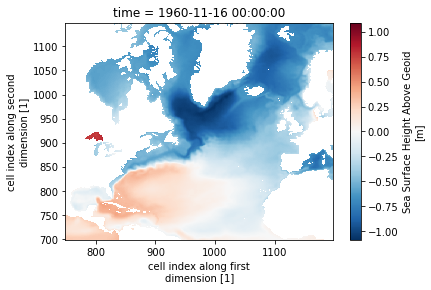

In [24]:
ds['zos'].isel(time=0).plot()

In [6]:
def Heat_transport(Temperature, Vel_u, Vel_v, Vel_w, dx, dy, dz, grid):
    
    Temp_u = grid.interp(Temperature, 'X', boundary='extend')
    Transport_u = grid.diff(Temp_u * Vel_u, 'X', boundary='fill') / dx
    
    Temp_v = grid.interp(Temperature, 'Y', boundary='extend')
    Transport_v = grid.diff(Temp_v * Vel_v, 'Y', boundary='fill') / dy
    
    Temp_w = grid.interp(Temperature, 'Z', boundary='extend')
    Transport_w = grid.diff(Temp_w * Vel_w, 'Z', boundary='fill') / dz
    
    return Transport_u, Transport_v, Transport_w

def Compute_Heat_transport(Field, Velocity, grid, dim, delta = 1., delta_v = 1., area = 1., const_multi = 1.):
    
    """Compute advective transport of field along velocity component 
    Parameters
    ----------
    Field : xarray DataArray - tracer field
    Velocity : xarray DataArray - velocity along any cartesian direction
    grid : xgcm Grid object
    dim : strig - dimension name
    delta : xarray DataArray - grid spacing across Velocity direction
    delta_v : xarray DataArray - grid spacing in the vertical direction (may include ssh variation)
    const_multi : constant - multiplier
    """
    
    Field_vel = grid.interp(Field, [dim], boundary='extend')
    Transport = grid.diff(Field_vel * Velocity * delta * delta_v, [dim], boundary='fill') / (area * delta_v)
    
    Transport = Transport * const_multi
    
    return Transport

In [8]:
rho_cp = 4.09 * 1.e6

Q = (rho_cp * ds['thetao'] * ds['dz_t'])

#HT_zon, HT_mer, HT_ver = Heat_transport(ds.thetao, ds.uo, ds.vo, ds.wo, ds.dx_t, ds.dy_t, ds.dz_t, grid)

#HT_zon = Compute_Heat_transport(ds.thetao, ds.uo, grid, 'X', delta = ds.dx_t, const_multi = rho_cp)
#HT_mer = Compute_Heat_transport(ds.thetao, ds.vo, grid, 'Y', delta = ds.dy_t, const_multi = rho_cp)
#HT_ver = Compute_Heat_transport(ds.thetao, ds.wo, grid, 'Z', delta = ds.dz_t, const_multi = rho_cp)

area_t = ds.area_t #ds.dy_t * ds.dx_t

HT_zon = Compute_Heat_transport(ds.thetao, ds.uo, grid, 'X', delta = ds.dy_u, 
                                delta_v = 1., area=area_t, const_multi = rho_cp)
HT_mer = Compute_Heat_transport(ds.thetao, ds.vo, grid, 'Y', delta = ds.dx_v, 
                                delta_v = 1., area=area_t, const_multi = rho_cp)
HT_ver = Compute_Heat_transport(ds.thetao, ds.wo, grid, 'Z', delta = 1., 
                                delta_v = 1., area = ds.dz_t, const_multi = rho_cp)

In [11]:
print("File size = ", (Q.astype(np.float32).nbytes/(75*1e9))*3*4*125/len(ds.time), " GB per hindcast per ensemble") 
print("File size = ", (Q.astype(np.float32).nbytes/(75*1e9))*3*4*125/len(ds.time)*10*57, " GB total") 

File size =  1.2149999999999999  GB per hindcast per ensemble
File size =  692.55  GB total


In [13]:
Q.astype(np.float32).nbytes*125/2/1e9

7.59375

In [9]:
print(Q, HT_zon, HT_mer, HT_ver)

<xarray.DataArray (time: 2, lev: 75, j: 450, i: 450)>
dask.array<mul, shape=(2, 75, 450, 450), dtype=float32, chunksize=(1, 75, 45, 450), chunktype=numpy.ndarray>
Coordinates:
  * j          (j) int64 699 700 701 702 703 704 ... 1144 1145 1146 1147 1148
  * i          (i) int64 749 750 751 752 753 754 ... 1194 1195 1196 1197 1198
  * time       (time) object 1960-11-16 00:00:00 1960-12-16 00:00:00
  * lev        (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    latitude   (j, i) float32 dask.array<chunksize=(21, 450), meta=np.ndarray>
    longitude  (j, i) float32 dask.array<chunksize=(21, 450), meta=np.ndarray>
    nav_lat    (j, i) float32 ...
    nav_lon    (j, i) float32 ... <xarray.DataArray (time: 2, lev: 75, j: 450, i: 450)>
dask.array<mul, shape=(2, 75, 450, 450), dtype=float32, chunksize=(1, 75, 45, 448), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) object 1960-11-16 00:00:00 1960-12-16 00:00:00
  * lev        (lev) float64 0.5058 1.556 2.668 ... 5.69

In [10]:
%time Q_full = Q.sum('lev').compute()
%time HT_x = (HT_zon * ds['dz_t']).sum('lev').compute()
%time HT_y = (HT_mer * ds['dz_t']).sum('lev').compute()
%time HT_z = (HT_ver * ds['dz_t']).sum('lev').compute()

CPU times: user 13.9 s, sys: 1.68 s, total: 15.6 s
Wall time: 15.2 s
CPU times: user 24 s, sys: 2.52 s, total: 26.6 s
Wall time: 26 s
CPU times: user 23.3 s, sys: 2.68 s, total: 26 s
Wall time: 25.3 s
CPU times: user 22.1 s, sys: 2.1 s, total: 24.2 s
Wall time: 24.2 s


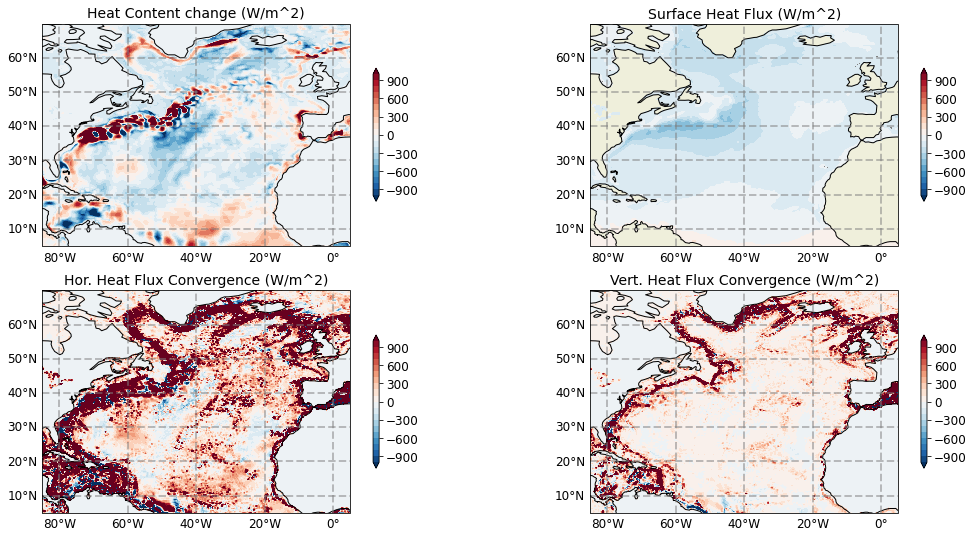

In [11]:
lat_lon_ext = [-85., 5., 5., 70.]

grid1 = plt.GridSpec(2, 2, wspace=0.2, hspace=0.2)
fig = plt.figure(figsize=[18,9])
  
ax = fig.add_subplot(grid1[0, 0], projection=ccrs.PlateCarree(),facecolor='grey')
[p, cb] = plot_sec(ax, Q_full.diff('time').mean('time') / (30*24*3600), vmin=-1000, vmax=1000,  lat_lon_ext = lat_lon_ext, levels = 21,
                   lon='longitude', lat='latitude', cmap='RdBu_r', title='Heat Content change (W/m^2)')

ax = fig.add_subplot(grid1[0, 1], projection=ccrs.PlateCarree(),facecolor='grey')
[p, cb] = plot_sec(ax, ds['hfds'].mean('time'), vmin=-1000, vmax=1000,  lat_lon_ext = lat_lon_ext, levels = 21,
                   lon='longitude', lat='latitude', cmap='RdBu_r', title='Surface Heat Flux (W/m^2)')

ax = fig.add_subplot(grid1[1, 0], projection=ccrs.PlateCarree(),facecolor='grey')
[p, cb] = plot_sec(ax, -(HT_y + HT_x).mean('time'), vmin=-1000, vmax=1000,  lat_lon_ext = lat_lon_ext, levels = 21,
                   lon='longitude', lat='latitude', cmap='RdBu_r', title='Hor. Heat Flux Convergence (W/m^2)')

ax = fig.add_subplot(grid1[1, 1], projection=ccrs.PlateCarree(),facecolor='grey')
[p, cb] = plot_sec(ax, -(HT_z + HT_y*0.).mean('time'), vmin=-1000, vmax=1000,  lat_lon_ext = lat_lon_ext, levels = 21,
                   lon='longitude', lat='latitude', cmap='RdBu_r', title='Vert. Heat Flux Convergence (W/m^2)')

In [51]:
print('Area integrated values')
print('Change in Q = ', (Q_full.diff('time').mean('time') * ds.area_t/ (30*24*3600)).sum(['i','j']).values/1e9) 
print('Surface Heat Flux = ', (ds['hfds'].mean('time') * ds.area_t).sum(['i','j']).values/1e9)
print('Heat Flux Convergence = ', ((-HT_y - HT_x - HT_z).mean('time') * ds.area_t).sum(['i','j']).values/1e9)
print('Residual = ', ((Q_full.diff('time').mean('time')/ (30*24*3600) - 
                       (ds['hfds'] - HT_y - HT_x - HT_z).mean('time'))* ds.area_t).sum(['i','j']).values/1e9)

Area integrated values
Change in Q =  -3941906.9466548255
Surface Heat Flux =  -5747745.35258112
Heat Flux Convergence =  5447720.948989952
Residual =  -3641882.210191345


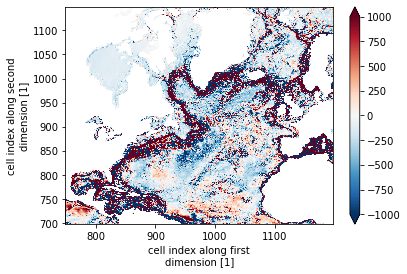

In [14]:
(ds['hfds']- HT_y - HT_x - HT_z).mean('time').plot(vmin=-1000, vmax=1000, cmap='RdBu_r', robust=True)

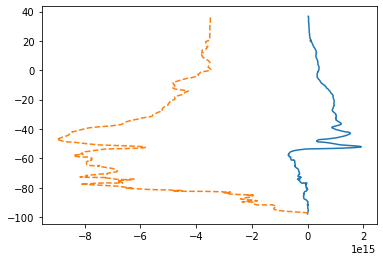

In [49]:
# Check u.theta term 

#tmp = grid.interp(ds.thetao, 'X', boundary='extend')
#%time Zon_HT = (ds.uo * tmp * ds['dz_t'] * rho_cp).sum('lev').mean('time').compute()  

Zon_HT1 = (Zon_HT * ds['dy_u'].where(ds['mask_North_Atl_u'] == 0.)).sum('j').compute()
lon = (ds['longitude_u'].where(ds['mask_North_Atl_u'] == 0.)).mean('j')
plt.plot(Zon_HT1, lon)

Zon_HT2 = (HT_x.mean('time') * area_t.where(ds['mask_North_Atl_t'] == 0.)).sum('j').compute()
lat = (ds['longitude'].where(ds['mask_North_Atl_t'] == 0.)).mean('j')

plt.plot(Zon_HT2.cumsum('i'), lon, '--')

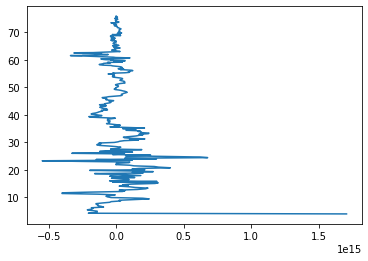

In [56]:
# with del.(T u)/dl
Mer_HT = (HT_y.mean('time') * ds['area_t'].where(ds['mask_North_Atl_t'] == 0.)).sum('i').compute()
lat = (ds['latitude'].where(ds['mask_North_Atl_t'] == 0.)).mean('i')

plt.plot(Mer_HT, lat)

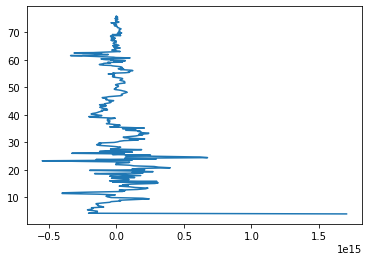

In [12]:
# with del.(dl T u)/dA
Mer_HT = (HT_y.mean('time') * ds['area_t'].where(ds['mask_North_Atl_t'] == 0.)).sum('i').compute()
lat = (ds['latitude'].where(ds['mask_North_Atl_t'] == 0.)).mean('i')

plt.plot(Mer_HT, lat)

In [13]:
tmp = grid.interp(ds.thetao, 'Y', boundary='extend')

%time Mer_HT = (ds.vo * tmp * ds['dz_t'] * rho_cp).sum('lev').mean('time').compute()  

CPU times: user 21.9 s, sys: 1.68 s, total: 23.6 s
Wall time: 26.3 s


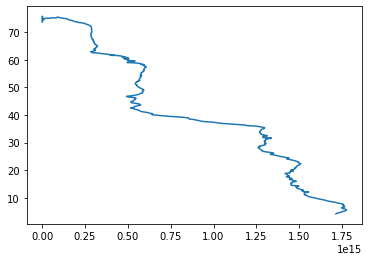

In [14]:
Mer_HT1 = (Mer_HT * ds['dx_v'].where(ds['mask_North_Atl_v'] == 0.)).sum('i').compute()
lat = (ds['latitude_v'].where(ds['mask_North_Atl_v'] == 0.)).mean('i')

plt.plot(Mer_HT1, lat)

In [17]:
%time Mer_HT_conv = (grid.diff(ds.vo * tmp * ds['dx_v'] * ds['dz_t'] * rho_cp, 'Y', boundary='fill') / ds.area_t).sum('lev').mean('time').compute()

CPU times: user 21.7 s, sys: 1.73 s, total: 23.4 s
Wall time: 21.8 s


In [22]:
grid

<xgcm.Grid>
Z Axis (not periodic, boundary=None):
  * center   lev --> right
  * right    lev_w --> center
X Axis (not periodic, boundary=None):
  * center   i --> right
  * right    i_c --> center
Y Axis (not periodic, boundary=None):
  * center   j --> right
  * right    j_c --> center

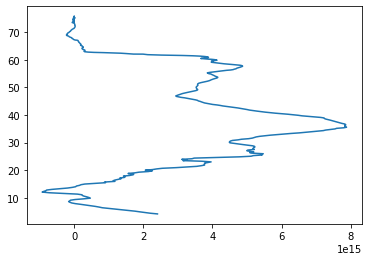

In [27]:
Mer_HT2 = (Mer_HT_conv * ds['area_t'].where(ds['mask_North_Atl_t'] == 0.)).sum('i').compute()

lat = (ds['latitude_v'].where(ds['mask_North_Atl_v'] == 0.)).mean('i')

plt.plot(Mer_HT2.cumsum('j') - Mer_HT2.cumsum('j').isel(j=-1), lat)

In [50]:
HT_zon1 = Compute_Heat_transport2(ds.thetao, ds.uo, grid, 'X', delta = ds.dx_u, const_multi = rho_cp)

HT_mer1 = Compute_Heat_transport2(ds.thetao, ds.vo, grid, 'Y', delta = ds.dy_v, const_multi = rho_cp)

HT_ver1 = Compute_Heat_transport2(ds.thetao, ds.wo, grid, 'Z', delta = ds.dz_w, const_multi = rho_cp)

print(HT_zon1, HT_mer1, HT_ver1)

<xarray.DataArray (time: 2, lev: 75, j: 450, i_c: 450)>
dask.array<mul, shape=(2, 75, 450, 450), dtype=float32, chunksize=(1, 75, 45, 449), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) object 1960-11-16 00:00:00 1960-12-16 00:00:00
  * lev          (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * j            (j) int64 699 700 701 702 703 704 ... 1144 1145 1146 1147 1148
  * i_c          (i_c) int64 749 750 751 752 753 ... 1194 1195 1196 1197 1198
    latitude_u   (j, i_c) float32 dask.array<chunksize=(21, 450), meta=np.ndarray>
    longitude_u  (j, i_c) float32 dask.array<chunksize=(21, 450), meta=np.ndarray> <xarray.DataArray (time: 2, lev: 75, j_c: 450, i: 450)>
dask.array<mul, shape=(2, 75, 450, 450), dtype=float32, chunksize=(1, 75, 44, 450), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) object 1960-11-16 00:00:00 1960-12-16 00:00:00
  * lev          (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * j_c          (j_c) int64 6

CPU times: user 21.3 s, sys: 2.11 s, total: 23.4 s
Wall time: 21.7 s


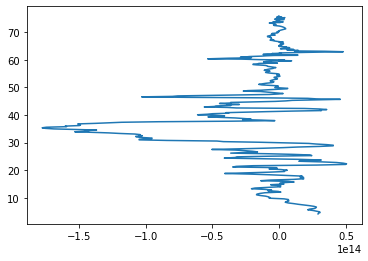

In [51]:
%time HT1_y = (HT_mer1 * ds['dz_t']).sum('lev').compute()

Mer_HT1 = (HT1_y.mean('time') * ds['area_v'].where(ds['mask_North_Atl_v'] == 0.)).sum('i').compute()
lat = (ds['latitude_v'].where(ds['mask_North_Atl_v'] == 0.)).mean('i')

plt.plot(Mer_HT1, lat)

In [25]:
print(ds.lev.values[38], ds.lev.values[45], ds.lev.values[56]) # mean depth level
print(ds.lev_w.values[39], ds.lev_w.values[46], ds.lev_w.values[57]) # depth level lower edge

457.6256103515625 947.4478759765625 2429.025146484375
482.4563293457031 995.6885375976562 2514.13720703125


In [31]:
print(ds.lev.values[30], ds.lev.values[48], ds.lev.values[56]) # mean depth level
print(ds.lev_w.values[31], ds.lev_w.values[49], ds.lev_w.values[57]) # depth level lower edge

199.7899627685547 1265.8614501953125 2429.025146484375
210.18446350097656 1325.6724853515625 2514.13720703125


In [75]:
#%time Q_500 = Q.isel(lev=slice(0,39)).sum('lev').compute()
#%time Q_1000 = Q.isel(lev=slice(39,46)).sum('lev').compute()
#%time Q_2500 = Q.isel(lev=slice(46,57)).sum('lev').compute()
%time Q_full = Q.sum('lev').compute()

CPU times: user 12.6 s, sys: 1.41 s, total: 14 s
Wall time: 13.7 s


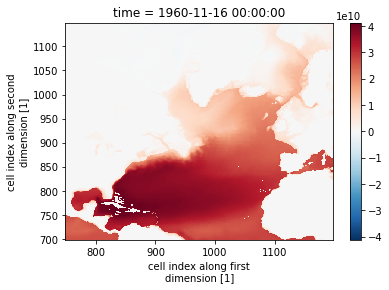

In [64]:
Q_500.isel(time=0).plot()

In [67]:
%time HT_500 = (HT_mer * ds['dz_t']).isel(lev=slice(0,39)).sum('lev').compute()
%time HT_1000 = (HT_mer * ds['dz_t']).isel(lev=slice(39,46)).sum('lev').compute()

CPU times: user 20.5 s, sys: 1.55 s, total: 22.1 s
Wall time: 20.6 s
CPU times: user 21 s, sys: 1.74 s, total: 22.8 s
Wall time: 21.3 s


In [15]:
levs = [0, 39]
tmp = (HT_mer * ds['dz_t']).isel(lev=slice(levs[0], levs[1])).sum('lev')
print(tmp)

<xarray.DataArray (time: 2, j: 450, i: 450)>
dask.array<sum-aggregate, shape=(2, 450, 450), dtype=float32, chunksize=(1, 43, 450), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) object 1960-11-16 00:00:00 1960-12-16 00:00:00
  * j          (j) int64 699 700 701 702 703 704 ... 1144 1145 1146 1147 1148
  * i          (i) int64 749 750 751 752 753 754 ... 1194 1195 1196 1197 1198
    latitude   (j, i) float32 dask.array<chunksize=(21, 450), meta=np.ndarray>
    longitude  (j, i) float32 dask.array<chunksize=(21, 450), meta=np.ndarray>
    nav_lat    (j, i) float32 ...
    nav_lon    (j, i) float32 ...


In [76]:
%time HT_full = ((HT_mer + HT_zon + HT_ver) * ds['dz_t']).sum('lev').compute()

CPU times: user 51.5 s, sys: 3.57 s, total: 55.1 s
Wall time: 58.6 s


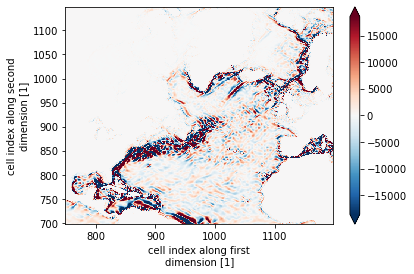

In [72]:
HT_500.mean('time').plot(robust=True) # meridional heat transport in upper 500 m

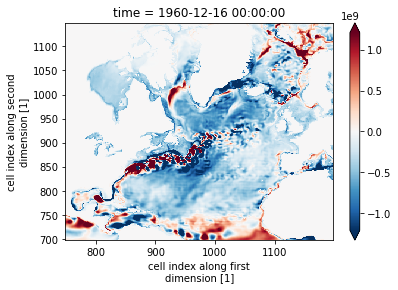

In [71]:
Q_500.diff('time').plot(robust=True) # heat content change in upper 500 m

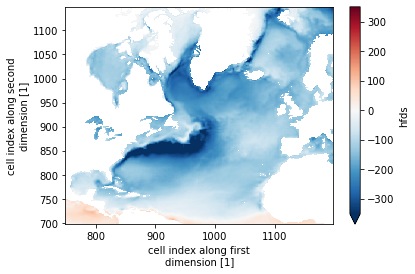

In [74]:
ds['hfds'].mean('time').plot(robust=True)

In [ ]:
fig = plt.figure(figsize=[18,3])

plt.subplot(1,3,1)
(Q_500.diff('time') / (30*24*3600)).plot(robust=True)

plt.subplot(1,3,2)
HT_full.mean('time').plot(robust=True, vmin=-500, vmax=500, cmap='coolwarm')

plt.subplot(1,3,3)
ds['hfds'].mean('time').plot(robust=True)

### Check heat budget calculation

In [10]:
def select_subset(dataset):
    
    """Select subset of dataset in xr.open_mfdataset command
    """
    dataset = dataset.isel(i=slice(749,1199), j = slice(699, 1149)) # indices range
    dataset = dataset.drop(['vertices_latitude', 'vertices_longitude', 
                            'time_bnds']) # drop variables 
    
    return dataset


year = 1961
r = 0

ppdir = "/gws/nopw/j04/snapdragon/hkhatri/Data_Heat_Budget/"

ds_grid = xr.open_dataset("/home/users/hkhatri/DePreSys4_Data/Data_Consolidated/Ocean_Area_Updated.nc")
ds_mask = xr.open_dataset("/home/users/hkhatri/DePreSys4_Data/Data_Consolidated/Mask_UVT_grid.nc")

ds = xr.open_dataset(ppdir + "Heat_Budget_"+ str(year) + "_r" + str(r+1) + ".nc", chunks={'time':1})

data_dir="/badc/cmip6/data/CMIP6/DCPP/MOHC/HadGEM3-GC31-MM/dcppA-hindcast/"

var_path = (data_dir + "s" + str(year) +"-r" + str(r+1) + 
            "i1p1f2/Omon/hfds/gn/latest/*.nc")

with xr.open_mfdataset(var_path, parallel=True, preprocess=select_subset, 
                       chunks={'time':1, 'j':45}, engine='netcdf4') as ds_hfds:
    ds_hfds = ds_hfds 

ds = xr.merge([ds, ds_hfds, ds_grid['area_t'].rename({'y':'j', 'x':'i'}), 
               ds_mask.drop(['nav_lat', 'nav_lon'])])
print(ds)

<xarray.Dataset>
Dimensions:                          (j: 450, i: 450, time: 125, j_c: 450,
                                      i_c: 450)
Coordinates:
  * j                                (j) int64 699 700 701 ... 1146 1147 1148
  * i                                (i) int64 749 750 751 ... 1196 1197 1198
  * time                             (time) object 1961-11-16 00:00:00 ... 19...
    latitude                         (j, i) float32 dask.array<chunksize=(21, 450), meta=np.ndarray>
    longitude                        (j, i) float32 dask.array<chunksize=(21, 450), meta=np.ndarray>
    nav_lat                          (j, i) float32 3.997 3.997 ... 73.34 73.24
    nav_lon                          (j, i) float32 -99.75 -99.5 ... 51.24 51.41
Dimensions without coordinates: j_c, i_c
Data variables: (12/14)
    Heat_Content_200                 (time, j, i) float32 dask.array<chunksize=(1, 450, 450), meta=np.ndarray>
    Heat_Content_1300                (time, j, i) float32 dask.array<ch

In [11]:
%%time
tmp1 = (ds['Heat_Content'].isel(time=-1) - ds['Heat_Content'].isel(time=0)).compute() / (124 * 30 * 24 * 3600)
tmp2 = ds['hfds'].mean('time').compute()

tmp3 = - (ds['Heat_Divergence_Vertical']).mean('time').compute()
tmp4 = - (ds['Heat_Divergence_Horizontal']).mean('time').compute()

#tmp3 = - (ds['Heat_Divergence_Vertical_200'] + ds['Heat_Divergence_Vertical_1300']).mean('time').compute()
#tmp4 = - (ds['Heat_Divergence_Horizontal_200'] + ds['Heat_Divergence_Horizontal_1300']).mean('time').compute()

CPU times: user 38.8 s, sys: 2.86 s, total: 41.7 s
Wall time: 40.9 s


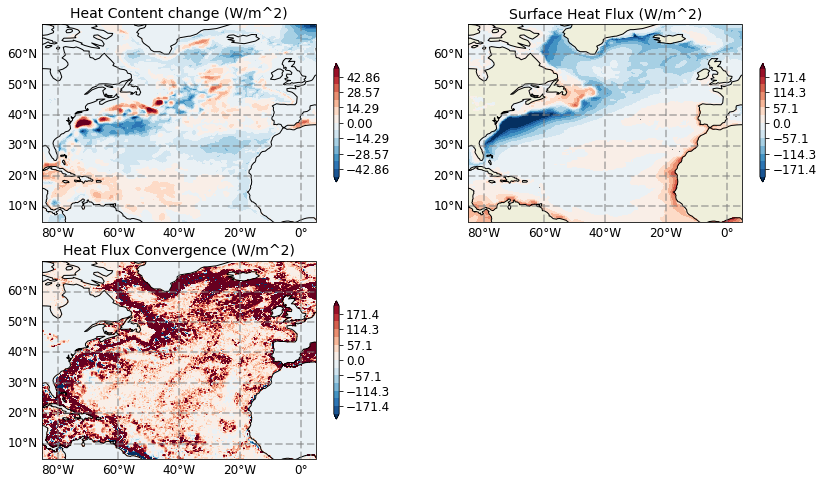

In [16]:
lat_lon_ext = [-85., 5., 5., 70.]

grid1 = plt.GridSpec(2, 2, wspace=0.2, hspace=0.2)
fig = plt.figure(figsize=[14,8])
  
ax = fig.add_subplot(grid1[0, 0], projection=ccrs.PlateCarree(),facecolor='grey')
[p, cb] = plot_sec(ax, tmp1, vmin=-50, vmax=50,  lat_lon_ext = lat_lon_ext, levels = 15,
                   lon='longitude', lat='latitude', cmap='RdBu_r', title='Heat Content change (W/m^2)')

ax = fig.add_subplot(grid1[0, 1], projection=ccrs.PlateCarree(),facecolor='grey')
[p, cb] = plot_sec(ax, tmp2, vmin=-200, vmax=200,  lat_lon_ext = lat_lon_ext, levels = 15,
                   lon='longitude', lat='latitude', cmap='RdBu_r', title='Surface Heat Flux (W/m^2)')

ax = fig.add_subplot(grid1[1, 0], projection=ccrs.PlateCarree(),facecolor='grey')
[p, cb] = plot_sec(ax, tmp3, vmin=-200, vmax=200,  lat_lon_ext = lat_lon_ext, levels = 15,
                   lon='longitude', lat='latitude', cmap='RdBu_r', title='Heat Flux Convergence (W/m^2)')

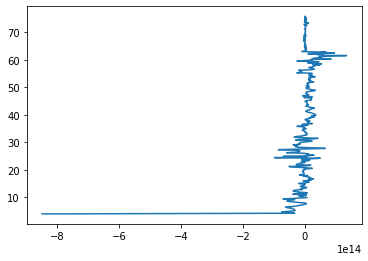

In [18]:
zonal_HT = ((-tmp3*0 + tmp4) * ds['area_t'].where(ds['mask_North_Atl_t'] == 0.)).sum('i').compute()
lat = (ds['latitude'].where(ds['mask_North_Atl_t'] == 0.)).mean('i')

plt.plot(zonal_HT, lat)

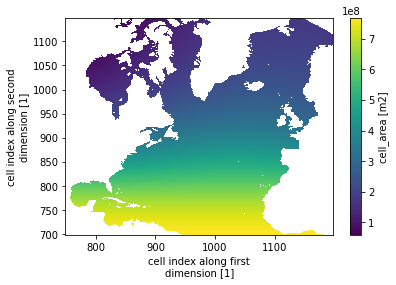

In [13]:
ds['area_t'].where(ds['mask_North_Atl_t'] == 0.).plot()

## Check Heat budget from model drift diagnostics

In [11]:
ppdir = "/gws/nopw/j04/snapdragon/hkhatri/Data_Drift/"

ds = []

for r in range(3,4):
    
    for lead_year in range(0, 11):
        
        d1 = xr.open_dataset(ppdir + "Heat_Budget/drift_budget_terms/Drift_Heat_Budget_r" + str(r+1) + 
                             "_Lead_Year_" + str(lead_year + 1) + ".nc", decode_times= False)
        
        d2 = xr.open_dataset(ppdir + "hfds/Drift_hfds_r" + str(r+1) + "_Lead_Year_" +
                             str(lead_year + 1) + ".nc", decode_times= False)
        
        d = xr.merge([d1, d2])
        d = d.assign(time_counter = np.arange(lead_year*12, 12*lead_year + 
                                              np.minimum(12, len(d['time'])), 1))
        
        ds.append(d)
        
    ds = xr.concat(ds, dim='time')
    
ds = ds.chunk({'time':1})
    
print(ds)

<xarray.Dataset>
Dimensions:                          (time_counter: 125, time: 125, j: 450,
                                      i: 450)
Coordinates:
  * time_counter                     (time_counter) int64 0 1 2 ... 122 123 124
  * j                                (j) int32 699 700 701 ... 1146 1147 1148
  * i                                (i) int32 749 750 751 ... 1196 1197 1198
    latitude                         (j, i) float32 dask.array<chunksize=(450, 450), meta=np.ndarray>
    longitude                        (j, i) float32 dask.array<chunksize=(450, 450), meta=np.ndarray>
    nav_lat                          (j, i) float32 dask.array<chunksize=(450, 450), meta=np.ndarray>
    nav_lon                          (j, i) float32 dask.array<chunksize=(450, 450), meta=np.ndarray>
Dimensions without coordinates: time
Data variables:
    Heat_Content_200                 (time, j, i) float32 dask.array<chunksize=(1, 450, 450), meta=np.ndarray>
    Heat_Content_1300                (ti

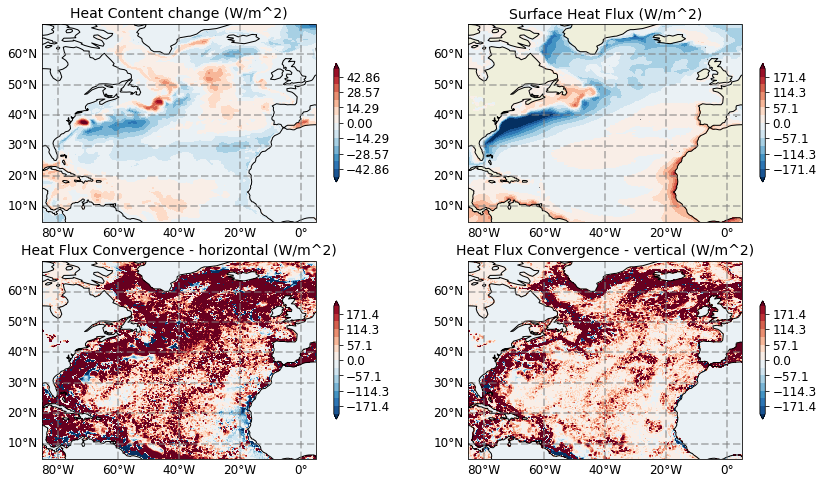

In [10]:
lat_lon_ext = [-85., 5., 5., 70.]

grid1 = plt.GridSpec(2, 2, wspace=0.2, hspace=0.2)
fig = plt.figure(figsize=[14,8])

tmp1 = (ds['Heat_Content'].isel(time=-1) - ds['Heat_Content'].isel(time=0)).compute() / (124 * 30 * 24 * 3600)
ax = fig.add_subplot(grid1[0, 0], projection=ccrs.PlateCarree(),facecolor='grey')
[p, cb] = plot_sec(ax, tmp1, vmin=-50, vmax=50,  lat_lon_ext = lat_lon_ext, levels = 15,
                   lon='longitude', lat='latitude', cmap='RdBu_r', title='Heat Content change (W/m^2)')

tmp2 = ds['hfds'].mean('time').compute()
ax = fig.add_subplot(grid1[0, 1], projection=ccrs.PlateCarree(),facecolor='grey')
[p, cb] = plot_sec(ax, tmp2, vmin=-200, vmax=200,  lat_lon_ext = lat_lon_ext, levels = 15,
                   lon='longitude', lat='latitude', cmap='RdBu_r', title='Surface Heat Flux (W/m^2)')

tmp3 = - (ds['Heat_Divergence_Vertical']).mean('time').compute()
tmp4 = - (ds['Heat_Divergence_Horizontal']).mean('time').compute()

ax = fig.add_subplot(grid1[1, 0], projection=ccrs.PlateCarree(),facecolor='grey')
[p, cb] = plot_sec(ax, tmp4, vmin=-200., vmax=200.,  lat_lon_ext = lat_lon_ext, levels = 15,
                   lon='longitude', lat='latitude', cmap='RdBu_r', title='Heat Flux Convergence - horizontal (W/m^2)')

ax = fig.add_subplot(grid1[1, 1], projection=ccrs.PlateCarree(),facecolor='grey')
[p, cb] = plot_sec(ax, tmp3, vmin=-200, vmax=200,  lat_lon_ext = lat_lon_ext, levels = 15,
                   lon='longitude', lat='latitude', cmap='RdBu_r', title='Heat Flux Convergence - vertical (W/m^2)')

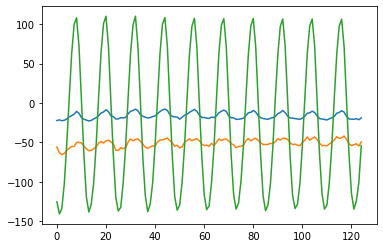

In [21]:
plt.plot(ds['Heat_Divergence_Vertical'].mean(['i','j']))
plt.plot(ds['Heat_Divergence_Horizontal'].mean(['i','j']))
plt.plot(ds['hfds'].mean(['i','j']))


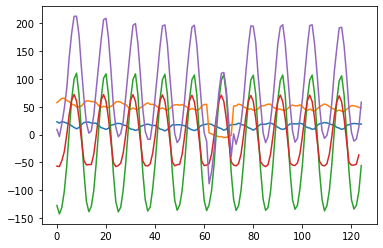

In [19]:
plt.plot(-ds['Heat_Divergence_Vertical'].mean(['i','j']))
plt.plot(-ds['Heat_Divergence_Horizontal'].mean(['i','j']))
plt.plot(ds['hfds'].mean(['i','j']))
plt.plot(ds['Heat_Content'].diff('time').mean(['i','j']) / (24.*3600.*30.))
plt.plot((-ds['Heat_Divergence_Vertical'] - ds['Heat_Divergence_Horizontal'] + ds['hfds']).mean(['i','j']))

There is weird peak in divergence term (visible in r = 1, 2). Let's try to compute heat budget drift terms directly from the full heat budget terms rather than model drift diagnostics. See if it helps. 

On the other hand, the magnitude looks fine but it might improve with the above-suggested aproach.

#### Update 

Drift diagnostics calculated directly from raw budget terms look better. There is no weird peak in divergence term. However, the spatial patterns and magnitudes in drift terms are roughly the same. This is good in the sense that both methods give roughly the same answers and enhanve our confidence in the approach.

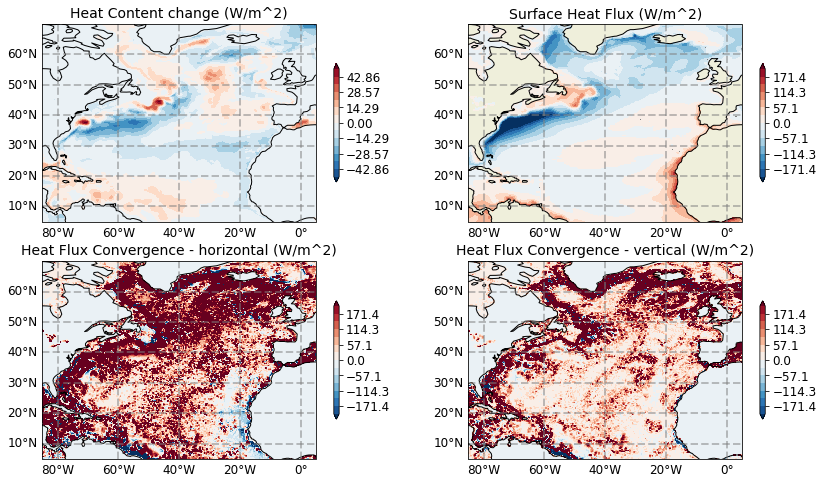

In [12]:
lat_lon_ext = [-85., 5., 5., 70.]

grid1 = plt.GridSpec(2, 2, wspace=0.2, hspace=0.2)
fig = plt.figure(figsize=[14,8])

tmp1 = (ds['Heat_Content'].isel(time=-1) - ds['Heat_Content'].isel(time=0)).compute() / (124 * 30 * 24 * 3600)
ax = fig.add_subplot(grid1[0, 0], projection=ccrs.PlateCarree(),facecolor='grey')
[p, cb] = plot_sec(ax, tmp1, vmin=-50, vmax=50,  lat_lon_ext = lat_lon_ext, levels = 15,
                   lon='longitude', lat='latitude', cmap='RdBu_r', title='Heat Content change (W/m^2)')

tmp2 = ds['hfds'].mean('time').compute()
ax = fig.add_subplot(grid1[0, 1], projection=ccrs.PlateCarree(),facecolor='grey')
[p, cb] = plot_sec(ax, tmp2, vmin=-200, vmax=200,  lat_lon_ext = lat_lon_ext, levels = 15,
                   lon='longitude', lat='latitude', cmap='RdBu_r', title='Surface Heat Flux (W/m^2)')

tmp3 = - (ds['Heat_Divergence_Vertical']).mean('time').compute()
tmp4 = - (ds['Heat_Divergence_Horizontal']).mean('time').compute()

ax = fig.add_subplot(grid1[1, 0], projection=ccrs.PlateCarree(),facecolor='grey')
[p, cb] = plot_sec(ax, tmp4, vmin=-200., vmax=200.,  lat_lon_ext = lat_lon_ext, levels = 15,
                   lon='longitude', lat='latitude', cmap='RdBu_r', title='Heat Flux Convergence - horizontal (W/m^2)')

ax = fig.add_subplot(grid1[1, 1], projection=ccrs.PlateCarree(),facecolor='grey')
[p, cb] = plot_sec(ax, tmp3, vmin=-200, vmax=200,  lat_lon_ext = lat_lon_ext, levels = 15,
                   lon='longitude', lat='latitude', cmap='RdBu_r', title='Heat Flux Convergence - vertical (W/m^2)')

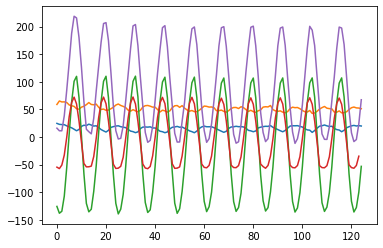

In [13]:
plt.plot(-ds['Heat_Divergence_Vertical'].mean(['i','j']))
plt.plot(-ds['Heat_Divergence_Horizontal'].mean(['i','j']))
plt.plot(ds['hfds'].mean(['i','j']))
plt.plot(ds['Heat_Content'].diff('time').mean(['i','j']) / (24.*3600.*30.))
plt.plot((-ds['Heat_Divergence_Vertical'] - ds['Heat_Divergence_Horizontal'] + ds['hfds']).mean(['i','j']))